In [1]:
!nvidia-smi

Sun Aug 24 05:36:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**Import And Split**

In [2]:
# ============================================================
# 0. Setup
# ============================================================
!pip install -q ultralytics

from ultralytics import YOLO
from pathlib import Path
import yaml, shutil, random, xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Dataset paths
BASE  = Path("/kaggle/input/bangladesh-traffic/Bangladeshi Traffic Flow Dataset/Annotated Images")
WORK  = Path("/kaggle/working/traffic_baseline")
SPLIT = WORK / "yolo_split"
DATA  = WORK / "data_traffic.yaml"
WORK.mkdir(parents=True, exist_ok=True)

# Custom folder for all outputs
OUTPUT_FOLDER = Path("/kaggle/working/base_yolov12")
OUTPUT_FOLDER.mkdir(parents=True, exist_ok=True)

# ============================================================
# 1. VOC → YOLO conversion + train/val/test split
# ============================================================
def voc2yolo(xml_file, classes, out_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    size = root.find("size")
    w, h = int(size.find("width").text), int(size.find("height").text)

    with open(out_file, "w") as f:
        for obj in root.iter("object"):
            cls = obj.find("name").text
            if cls not in classes:
                continue
            cls_id = classes.index(cls)

            xmlbox = obj.find("bndbox")
            xmin, ymin = float(xmlbox.find("xmin").text), float(xmlbox.find("ymin").text)
            xmax, ymax = float(xmlbox.find("xmax").text), float(xmlbox.find("ymax").text)

            x = (xmin + xmax) / 2.0 / w
            y = (ymin + ymax) / 2.0 / h
            bw = (xmax - xmin) / w
            bh = (ymax - ymin) / h
            f.write(f"{cls_id} {x:.6f} {y:.6f} {bw:.6f} {bh:.6f}\n")

def create_split(all_files, ratios=(0.7,0.2,0.1)):
    n = len(all_files)
    n_train = int(ratios[0]*n)
    n_val   = int(ratios[1]*n)
    random.shuffle(all_files)
    return (all_files[:n_train],
            all_files[n_train:n_train+n_val],
            all_files[n_train+n_val:])

def convert_and_split(base_dir, classes, ratios=(0.7,0.2,0.1)):
    if SPLIT.exists():
        shutil.rmtree(SPLIT)

    all_pairs = []
    for ext in ["*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG"]:
        for img_file in Path(base_dir).rglob(ext):
            xml_file = img_file.with_suffix(".xml")
            if xml_file.exists():
                all_pairs.append((img_file, xml_file))

    print(f"Found {len(all_pairs)} annotated images total.")
    train, val, test = create_split(all_pairs, ratios)
    splits = {"train":train, "val":val, "test":test}

    for split_name, files in splits.items():
        out_im, out_lb = SPLIT/split_name/"images", SPLIT/split_name/"labels"
        out_im.mkdir(parents=True, exist_ok=True)
        out_lb.mkdir(parents=True, exist_ok=True)

        for img_file, xml_file in files:
            shutil.copy(img_file, out_im/img_file.name)
            voc2yolo(xml_file, classes, out_lb/f"{img_file.stem}.txt")
        print(f"{split_name}: {len(files)} images")

# Classes in dataset
CLASSES = ["Rickshaw","Bus","Truck","Bike","Mini-truck","People","Car","CNG","Cycle"]

print("➤ Converting Pascal VOC → YOLO with auto split …")
convert_and_split(BASE, CLASSES, ratios=(0.7,0.2,0.1))

# Create data.yaml for YOLOv12
DATA.write_text(yaml.dump({
    "path": str(SPLIT),
    "train": "train/images",
    "val": "val/images",
    "test": "test/images",
    "nc": len(CLASSES),
    "names": CLASSES
}))
print("✓ YOLO split ready:", DATA)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.8 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultraly

**Train Yolo Baseline**

In [3]:
# ============================================================
# 2. Train YOLOv12 baseline (outputs in custom folder)
# ============================================================
model = YOLO("yolo12s.pt")  # baseline small version
model.train(
    data=str(DATA),
    epochs=50,        # increase if resources allow
    imgsz=640,
    batch=16,
    workers=2,
    project=str(OUTPUT_FOLDER),  # <- save all outputs here
    name="train"                 # <- folder name inside project
)


Ultralytics 8.3.184 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/traffic_baseline/data_traffic.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True,

Overriding model.yaml nc=80 with nc=9

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    689408  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytics

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1022.0±332.8 MB/s, size: 70.4 KB)


train: Scanning /kaggle/working/traffic_baseline/yolo_split/train/labels... 16574 images, 34 backgrounds, 0 corrupt: 100%|██████████| 16574/16574 [00:11<00:00, 1401.84it/s]

train: /kaggle/working/traffic_baseline/yolo_split/train/images/frame0_jpg.rf.e1bc04102d10d13d3e4801450a664640.jpg: 2 duplicate labels removed


train: New cache created: /kaggle/working/traffic_baseline/yolo_split/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 809.5±630.6 MB/s, size: 74.0 KB)


val: Scanning /kaggle/working/traffic_baseline/yolo_split/val/labels... 4735 images, 14 backgrounds, 0 corrupt: 100%|██████████| 4735/4735 [00:03<00:00, 1389.40it/s]

val: /kaggle/working/traffic_baseline/yolo_split/val/images/frame195_jpg.rf.46fd02322bca0e4c4437d57807d7a178.jpg: 1 duplicate labels removed
val: /kaggle/working/traffic_baseline/yolo_split/val/images/frame1_jpg.rf.af73293c83d849389bfeacd60c71cd38.jpg: 1 duplicate labels removed


val: New cache created: /kaggle/working/traffic_baseline/yolo_split/val/labels.cache
Plotting labels to /kaggle/working/base_yolov12/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /kaggle/working/base_yolov12/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.99G      1.405      1.219      1.126        265        640: 100%|██████████| 1036/1036 [07:48<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:42<00:00,  3.46it/s]


                   all       4735      46700      0.714      0.613      0.639      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.26G      1.314     0.9472      1.076        255        640: 100%|██████████| 1036/1036 [07:43<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:42<00:00,  3.49it/s]


                   all       4735      46700      0.718      0.591      0.646      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.29G      1.345     0.9744      1.094        207        640: 100%|██████████| 1036/1036 [07:40<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:42<00:00,  3.52it/s]


                   all       4735      46700      0.687      0.594      0.619      0.371

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.31G      1.338      0.971      1.096        217        640: 100%|██████████| 1036/1036 [07:39<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:42<00:00,  3.51it/s]


                   all       4735      46700      0.597      0.616      0.637      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.34G      1.299     0.9265      1.078        261        640: 100%|██████████| 1036/1036 [07:38<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:41<00:00,  3.53it/s]


                   all       4735      46700      0.723      0.611      0.658      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.37G      1.268      0.894      1.071        267        640: 100%|██████████| 1036/1036 [07:38<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:41<00:00,  3.53it/s]


                   all       4735      46700      0.591      0.665      0.668      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.39G      1.252     0.8731      1.064        276        640: 100%|██████████| 1036/1036 [07:38<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:41<00:00,  3.56it/s]


                   all       4735      46700      0.622      0.627      0.661      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.42G      1.236     0.8526      1.055        272        640: 100%|██████████| 1036/1036 [07:38<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:41<00:00,  3.54it/s]


                   all       4735      46700      0.642      0.672       0.69      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.45G      1.222     0.8411      1.051        256        640: 100%|██████████| 1036/1036 [07:38<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:41<00:00,  3.55it/s]


                   all       4735      46700      0.609       0.69       0.69      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.47G      1.215     0.8332      1.048        276        640: 100%|██████████| 1036/1036 [07:38<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:42<00:00,  3.52it/s]


                   all       4735      46700      0.664      0.657      0.704      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       6.5G      1.202     0.8163      1.042        262        640: 100%|██████████| 1036/1036 [07:38<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:41<00:00,  3.56it/s]


                   all       4735      46700      0.662      0.665      0.694      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.52G      1.192     0.8062      1.038        185        640: 100%|██████████| 1036/1036 [07:38<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:41<00:00,  3.53it/s]


                   all       4735      46700      0.599      0.712      0.703      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.55G      1.183     0.7981      1.035        189        640: 100%|██████████| 1036/1036 [07:38<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:41<00:00,  3.54it/s]


                   all       4735      46700      0.653      0.677      0.706       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.58G      1.179     0.7921      1.034        242        640: 100%|██████████| 1036/1036 [07:38<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:41<00:00,  3.55it/s]


                   all       4735      46700      0.647      0.674      0.708      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       6.6G      1.173     0.7861      1.031        305        640: 100%|██████████| 1036/1036 [07:38<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:41<00:00,  3.56it/s]


                   all       4735      46700      0.661      0.678      0.713      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.63G      1.164     0.7779      1.028        186        640: 100%|██████████| 1036/1036 [07:38<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:41<00:00,  3.55it/s]


                   all       4735      46700      0.641      0.691      0.716       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.65G      1.157     0.7697      1.026        211        640: 100%|██████████| 1036/1036 [07:39<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:41<00:00,  3.57it/s]


                   all       4735      46700      0.655      0.688      0.719      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.68G      1.152     0.7638      1.024        229        640: 100%|██████████| 1036/1036 [07:38<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:41<00:00,  3.55it/s]


                   all       4735      46700      0.653      0.709      0.729      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.71G      1.148     0.7576      1.021        299        640: 100%|██████████| 1036/1036 [07:39<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:41<00:00,  3.56it/s]


                   all       4735      46700      0.629      0.713      0.724      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.73G      1.141     0.7529      1.018        185        640: 100%|██████████| 1036/1036 [07:39<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:41<00:00,  3.55it/s]


                   all       4735      46700      0.662      0.705      0.728      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.76G      1.138     0.7493      1.017        201        640: 100%|██████████| 1036/1036 [07:39<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:41<00:00,  3.55it/s]


                   all       4735      46700      0.631      0.729      0.727      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.78G       1.13     0.7438      1.013        274        640: 100%|██████████| 1036/1036 [07:39<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:42<00:00,  3.52it/s]


                   all       4735      46700      0.638      0.718      0.733      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.81G      1.126     0.7377      1.013        223        640: 100%|██████████| 1036/1036 [07:39<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:41<00:00,  3.53it/s]


                   all       4735      46700      0.652      0.714      0.734      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.84G       1.12     0.7323       1.01        239        640: 100%|██████████| 1036/1036 [07:39<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:42<00:00,  3.52it/s]


                   all       4735      46700      0.679      0.695      0.735      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.86G      1.115     0.7292      1.009        154        640: 100%|██████████| 1036/1036 [07:39<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:42<00:00,  3.52it/s]


                   all       4735      46700      0.652      0.715      0.736        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.89G      1.109      0.722      1.005        230        640: 100%|██████████| 1036/1036 [07:39<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:41<00:00,  3.54it/s]


                   all       4735      46700      0.624      0.736      0.736        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.91G      1.103     0.7139      1.002        220        640: 100%|██████████| 1036/1036 [07:39<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:41<00:00,  3.55it/s]


                   all       4735      46700      0.671      0.702      0.733        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.94G        1.1     0.7112      1.002        219        640: 100%|██████████| 1036/1036 [07:39<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:41<00:00,  3.53it/s]


                   all       4735      46700      0.668      0.721      0.746      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.96G      1.095     0.7052          1        242        640: 100%|██████████| 1036/1036 [07:40<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:42<00:00,  3.51it/s]


                   all       4735      46700      0.662      0.711       0.74      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.99G       1.09     0.7026     0.9972        209        640: 100%|██████████| 1036/1036 [07:39<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:42<00:00,  3.52it/s]


                   all       4735      46700      0.679      0.706      0.741      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.02G      1.083     0.6964     0.9949        267        640: 100%|██████████| 1036/1036 [07:39<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:41<00:00,  3.53it/s]


                   all       4735      46700       0.68      0.713      0.744       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.04G       1.08     0.6898     0.9924        312        640: 100%|██████████| 1036/1036 [07:40<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:41<00:00,  3.53it/s]


                   all       4735      46700      0.673      0.712      0.745      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.07G      1.076     0.6863     0.9929        219        640: 100%|██████████| 1036/1036 [07:39<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:41<00:00,  3.53it/s]


                   all       4735      46700      0.678      0.706      0.742      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       7.1G      1.073     0.6831     0.9898        264        640: 100%|██████████| 1036/1036 [07:39<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:42<00:00,  3.50it/s]

                   all       4735      46700      0.665      0.725      0.746      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.12G      1.063     0.6787     0.9886        155        640: 100%|██████████| 1036/1036 [07:39<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:41<00:00,  3.53it/s]


                   all       4735      46700      0.675      0.715      0.746      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.15G      1.059     0.6713     0.9858        218        640: 100%|██████████| 1036/1036 [07:40<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:41<00:00,  3.53it/s]


                   all       4735      46700      0.679      0.705      0.741      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.17G      1.055     0.6644     0.9841        214        640: 100%|██████████| 1036/1036 [07:40<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:41<00:00,  3.53it/s]


                   all       4735      46700      0.665      0.706      0.741      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       7.2G      1.049     0.6605     0.9821        235        640: 100%|██████████| 1036/1036 [07:40<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:41<00:00,  3.53it/s]


                   all       4735      46700       0.67      0.709       0.74      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.23G      1.044     0.6564     0.9811        187        640: 100%|██████████| 1036/1036 [07:40<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:41<00:00,  3.55it/s]

                   all       4735      46700      0.667      0.709       0.74      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.25G      1.035     0.6503     0.9768        243        640: 100%|██████████| 1036/1036 [07:40<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:42<00:00,  3.52it/s]

                   all       4735      46700      0.675      0.712      0.743      0.513


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.28G      1.021     0.6138     0.9769        139        640: 100%|██████████| 1036/1036 [07:35<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:42<00:00,  3.52it/s]

                   all       4735      46700      0.661      0.717       0.74      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       7.3G      1.007     0.6037     0.9719        116        640: 100%|██████████| 1036/1036 [07:34<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:42<00:00,  3.52it/s]

                   all       4735      46700      0.662      0.724      0.741      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.33G     0.9984     0.5936     0.9696         96        640: 100%|██████████| 1036/1036 [07:35<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:41<00:00,  3.54it/s]

                   all       4735      46700      0.684      0.704      0.742      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.36G       0.99      0.587     0.9646        133        640: 100%|██████████| 1036/1036 [07:33<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:41<00:00,  3.55it/s]

                   all       4735      46700      0.673      0.712      0.743      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.38G     0.9823     0.5786     0.9629        120        640: 100%|██████████| 1036/1036 [07:34<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:42<00:00,  3.51it/s]


                   all       4735      46700      0.667      0.722      0.742      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.46G      0.973     0.5709     0.9593        136        640: 100%|██████████| 1036/1036 [07:33<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:42<00:00,  3.49it/s]

                   all       4735      46700      0.673      0.711      0.741      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.46G     0.9655     0.5629     0.9556        130        640: 100%|██████████| 1036/1036 [07:33<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:41<00:00,  3.53it/s]

                   all       4735      46700      0.684      0.706      0.742      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.46G     0.9572      0.556     0.9523        137        640: 100%|██████████| 1036/1036 [07:33<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:41<00:00,  3.53it/s]

                   all       4735      46700      0.679      0.711      0.741      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.46G       0.95     0.5486     0.9515        125        640: 100%|██████████| 1036/1036 [07:34<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:42<00:00,  3.52it/s]

                   all       4735      46700      0.676      0.714       0.74      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.46G     0.9421     0.5424     0.9469        137        640: 100%|██████████| 1036/1036 [07:33<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:42<00:00,  3.51it/s]

                   all       4735      46700      0.675      0.718       0.74      0.512



50 epochs completed in 6.964 hours.
Optimizer stripped from /kaggle/working/base_yolov12/train/weights/last.pt, 18.9MB
Optimizer stripped from /kaggle/working/base_yolov12/train/weights/best.pt, 18.9MB

Validating /kaggle/working/base_yolov12/train/weights/best.pt...
Ultralytics 8.3.184 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,234,363 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:44<00:00,  3.32it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       4735      46700      0.671      0.713      0.743      0.514
              Rickshaw       3895      12049      0.772      0.854      0.899      0.629
                   Bus       3873      10374      0.774      0.863      0.896       0.66
                 Truck        245        272      0.425      0.452      0.457      0.359
                  Bike       2109       3214      0.739      0.798      0.848      0.521
                People       2895       7796      0.758      0.819      0.869      0.555
                   Car       4295      12849      0.821      0.894      0.935      0.707
                 Cycle        138        146      0.409      0.308      0.295      0.169
Speed: 0.1ms preprocess, 5.2ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /kaggle/working/base_yolov12/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 5, 6, 8])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e298ca08890>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
  

**Evaluate**

In [4]:
# ============================================================
# 3. Evaluate on test set + generate plots (outputs in same folder)
# ============================================================
metrics = model.val(
    data=str(DATA),
    split="test",
    plots=True,
    project=str(OUTPUT_FOLDER),  # <- same output folder
    name="val"
)

print("mAP@0.5     :", metrics.box.map50)
print("mAP@[.5:.95]:", metrics.box.map)
print("Precision   :", metrics.box.mp)
print("Recall      :", metrics.box.mr)

Ultralytics 8.3.184 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,234,363 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1315.3±307.4 MB/s, size: 62.6 KB)


val: Scanning /kaggle/working/traffic_baseline/yolo_split/test/labels... 2369 images, 7 backgrounds, 0 corrupt: 100%|██████████| 2369/2369 [00:01<00:00, 1422.05it/s]

val: New cache created: /kaggle/working/traffic_baseline/yolo_split/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 149/149 [00:33<00:00,  4.40it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2369      23130       0.66      0.713      0.745      0.516
              Rickshaw       1923       5972      0.776      0.868      0.907      0.633
                   Bus       1969       5281      0.776      0.876      0.901      0.665
                 Truck        111        123      0.455      0.475      0.515      0.406
                  Bike       1037       1527      0.712      0.807      0.833      0.515
                People       1485       3872      0.748      0.825      0.866      0.557
                   Car       2124       6271      0.804      0.903      0.931      0.703
                 Cycle         82         84       0.35      0.238      0.262      0.133
Speed: 0.2ms preprocess, 10.3ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /kaggle/working/base_yolov12/val
mAP@0.5     : 0.7451543401025381
mAP@[.5:.95]: 0.516012399858971
Precision   : 0.6599287647825518
Recall      : 0.7131963459623197


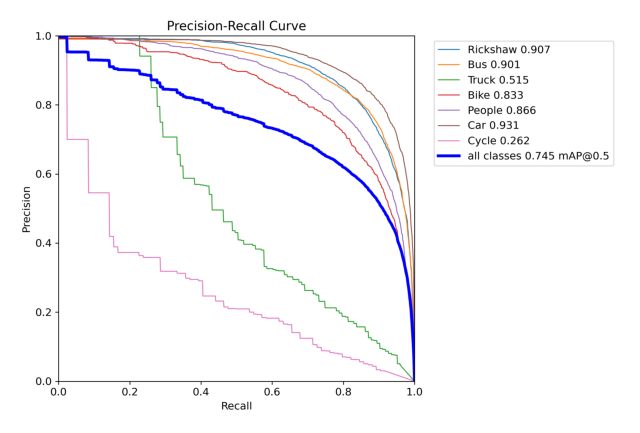

In [5]:
# ============================================================
# 4. Visualize PR curve from custom folder
# ============================================================
pr_curve_file = list((OUTPUT_FOLDER/"val").glob("*PR_curve*.png"))[0]
img = mpimg.imread(pr_curve_file)
plt.figure(figsize=(8,6))
plt.imshow(img)
plt.axis('off')
plt.show()

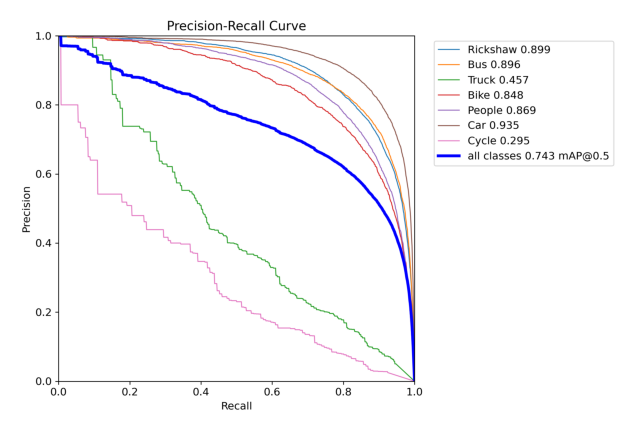

In [6]:
# ============================================================
# 5. Visualize PR curve from train folder
# ============================================================
box_pr_curve_file = list((OUTPUT_FOLDER/"train").glob("*BoxPR_curve*.png"))[0]
img = mpimg.imread(box_pr_curve_file)
plt.figure(figsize=(8,6))
plt.imshow(img)
plt.axis('off')
plt.show()

In [7]:
# ============================================================
# 6. Model speed / latency (FPS)
# ============================================================
results = model(str(SPLIT/"test/images"), device=0, imgsz=640, verbose=False)
fps = 1000.0 / results[0].speed['inference']
print("FPS ≈", fps)



WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

FPS ≈ 19.140293064284624


In [8]:
#best model

from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path

# Path to your trained model
best_model_path = Path("/kaggle/working/base_yolov12/train/weights/best.pt")

# Load the trained YOLOv12 model
model = YOLO(str(best_model_path))

# ============================================================
# Evaluate on test set
# ============================================================
DATA = "/kaggle/working/traffic_baseline/data_traffic.yaml"

metrics = model.val(
    data=DATA,
    split="test",
    plots=True,           # generates PR curve, confusion matrix, etc.
    project="/kaggle/working/base_yolov12",
    name="val"
)

print("mAP@0.5     :", metrics.box.map50)
print("mAP@[.5:.95]:", metrics.box.map)
print("Precision   :", metrics.box.mp)
print("Recall      :", metrics.box.mr)


# ============================================================
# 3. Inference on test images + FPS
# ============================================================
results = model("/kaggle/working/traffic_baseline/yolo_split/test/images", device=0, imgsz=640, verbose=False)
fps = 1000.0 / results[0].speed['inference']
print("FPS ≈", fps)

# ============================================================
# Model complexity (params / GMACs)
# ============================================================
model.info(detailed=True)


Ultralytics 8.3.184 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,234,363 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1345.5±453.2 MB/s, size: 60.9 KB)


val: Scanning /kaggle/working/traffic_baseline/yolo_split/test/labels.cache... 2369 images, 7 backgrounds, 0 corrupt: 100%|██████████| 2369/2369 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 149/149 [00:33<00:00,  4.50it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2369      23130       0.66      0.713      0.745      0.516
              Rickshaw       1923       5972      0.776      0.868      0.907      0.633
                   Bus       1969       5281      0.776      0.876      0.901      0.665
                 Truck        111        123      0.455      0.475      0.515      0.406
                  Bike       1037       1527      0.712      0.807      0.833      0.515
                People       1485       3872      0.748      0.825      0.866      0.557
                   Car       2124       6271      0.804      0.903      0.931      0.703
                 Cycle         82         84       0.35      0.238      0.262      0.133
Speed: 0.3ms preprocess, 10.1ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /kaggle/working/base_yolov12/val2
mAP@0.5     : 0.7451543401025381
mAP@[.5:.95]: 0.516012399858971
Precision   : 0.6599287647825518
Recall      : 0.7131963459623197
WARNING ⚠️ 
inference r

(159, 9234363, 0, 21.227980799999997)